In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
!unzip /content/drive/MyDrive/cassandra23/cassandra23-ps-2.zip

Archive:  /content/drive/MyDrive/cassandra23/cassandra23-ps-2.zip
replace dataset/sample_submissions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset/sample_submissions.csv  
  inflating: dataset/test_data.csv   
  inflating: dataset/train_data.csv  


In [65]:
import pandas as pd
import numpy as np
import gc


## Loading dataset

In [66]:
train_df = pd.read_csv('dataset/train_data.csv')
test_df = pd.read_csv('dataset/test_data.csv')
sample_submission = pd.read_csv('dataset/sample_submissions.csv')


In [67]:
train_df.head()

,UID,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,...,cutoff_timestamp,actual_distance_to_destination,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor,actual_time
0,lWYYrbNEdf,2018-09-15 02:23:18.656742,thanos::sroute:9d8ed3f7-a8af-4393-ad7a-c57a720...,FTL,trip-153697819865649878,IND832109AAB,Jamshedpur_Central_I_3 (Jharkhand),IND834002AAB,Ranchi_Hub (Jharkhand),2018-09-15 02:23:18.656742,...,2018-09-15 04:45:23,158.807515,778.672716,1228.735753,2.782826,77.988686,20.793472,28.475783,3.292773,100.0
1,iNJcHQlPCm,2018-09-30 15:07:48.971326,thanos::sroute:b9142a73-d68f-46ec-9afc-d145479...,FTL,trip-153832006897106333,IND422011AAD,Nashik_TgrniaRD_I (Maharashtra),IND421302AAG,Bhiwandi_Mankoli_HB (Maharashtra),2018-09-30 22:38:13.903069,...,2018-10-01 05:38:30,81.388109,227.479029,NaN,3.625248,68.517914,18.787231,34.612259,4.277350,61.0
2,U6N0M43qwR,2018-09-23 22:15:46.635975,thanos::sroute:883e99fa-50a3-40e0-a2e2-9b12ed6...,FTL,trip-153774094663572416,IND845305AAA,Raxaul_KairiyaT_D (Bihar),NaN,Muzaffrpur_Bbganj_I (Bihar),2018-09-24 03:56:37.016232,...,2018-09-24 09:21:30,134.486898,400.072069,1188.943158,4.415969,70.475386,24.371978,29.867950,5.322072,69.0
3,RrJUneuYNj,2018-09-21 05:11:44.833176,thanos::sroute:96a80600-40e1-436b-9161-fa68f9e...,FTL,trip-153750670483274503,IND842001AAA,Muzaffrpur_Bbganj_I (Bihar),IND854326AAB,Purnia_Central_H_2 (Bihar),2018-09-22 10:08:32.593022,...,2018-09-22 14:09:17,262.866674,510.123878,999.421258,2.946647,101.876844,19.588977,27.794019,4.265799,300.0
4,7QLdD7iRC9,2018-09-18 01:10:49.936747,thanos::sroute:b43ec86d-59c1-452c-b4a9-807d357...,FTL,trip-153723305402762987,IND411033AAA,Pune_Tathawde_H (Maharashtra),IND501359AAE,Hyderabad_Shamshbd_H (Telangana),2018-09-18 01:10:49.936747,...,2018-09-18 12:14:05,379.389280,NaN,NaN,1.998790,46.571301,22.671495,26.971844,3.553652,286.0


In [68]:
train_df.columns

Index(['UID', 'trip_creation_time', 'route_schedule_uuid', 'route_type',
       'trip_uuid', 'source_center', 'source_name', 'destination_center',
       'destination_name', 'od_start_time', 'od_end_time',
       'start_scan_to_end_scan', 'is_cutoff', 'cutoff_factor',
       'cutoff_timestamp', 'actual_distance_to_destination', 'osrm_time',
       'osrm_distance', 'factor', 'segment_actual_time', 'segment_osrm_time',
       'segment_osrm_distance', 'segment_factor', 'actual_time'],
      dtype='object')

#Preprocessing

## Changing all the date and time object category to datetime type

In [69]:
# Convert object columns in train data to datetime
train_df['trip_creation_time'] = pd.to_datetime(train_df['trip_creation_time'])
train_df['od_start_time'] = pd.to_datetime(train_df['od_start_time'])
train_df['od_end_time'] = pd.to_datetime(train_df['od_end_time'])
train_df['cutoff_timestamp'] = pd.to_datetime(train_df['cutoff_timestamp'])

# Convert object columns in test data to datetime
test_df['trip_creation_time'] = pd.to_datetime(test_df['trip_creation_time'])
test_df['od_start_time'] = pd.to_datetime(test_df['od_start_time'])
test_df['od_end_time'] = pd.to_datetime(test_df['od_end_time'])
test_df['cutoff_timestamp'] = pd.to_datetime(test_df['cutoff_timestamp'])

# Convert is_cutoff and route_type column to int
train_df['is_cutoff'] = train_df['is_cutoff'].astype(int)
test_df['is_cutoff'] = test_df['is_cutoff'].astype(int)

replace_dict = {'FTL':1,'Carting':0}
train_df['route_type'] = train_df['route_type'].replace(replace_dict)
test_df['route_type'] = test_df['route_type'].replace(replace_dict)

In [70]:
print(train_df.info())
print("="*98)
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72158 entries, 0 to 72157
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   UID                             72158 non-null  object        
 1   trip_creation_time              68643 non-null  datetime64[ns]
 2   route_schedule_uuid             69263 non-null  object        
 3   route_type                      72158 non-null  int64         
 4   trip_uuid                       72158 non-null  object        
 5   source_center                   72158 non-null  object        
 6   source_name                     72158 non-null  object        
 7   destination_center              71355 non-null  object        
 8   destination_name                72158 non-null  object        
 9   od_start_time                   72158 non-null  datetime64[ns]
 10  od_end_time                     71438 non-null  datetime64[ns]
 11  st

In [71]:
train_df['od_actual']=(train_df.od_end_time - train_df.od_start_time).dt.total_seconds()/3600
test_df['od_actual']=(test_df.od_end_time - test_df.od_start_time).dt.total_seconds()/3600

train_df['trip_create_to_trip_start']=(train_df.od_start_time - train_df.trip_creation_time).dt.total_seconds()/3600
test_df['trip_create_to_trip_start']=(test_df.od_start_time - test_df.trip_creation_time).dt.total_seconds()/3600

train_df['trip_create_to_trip_end']=(train_df.od_end_time - train_df.trip_creation_time).dt.total_seconds()/3600
test_df['trip_create_to_trip_end']=(test_df.od_end_time - test_df.trip_creation_time).dt.total_seconds()/3600

train_df['trip_create_to_cutoff']=(train_df.cutoff_timestamp - train_df.trip_creation_time).dt.total_seconds()/3600
test_df['trip_create_to_cutoff']=(test_df.cutoff_timestamp - test_df.trip_creation_time).dt.total_seconds()/3600

train_df['od_start_to_cutoff']=(train_df.cutoff_timestamp - train_df.od_start_time).dt.total_seconds()/3600
test_df['od_start_to_cutoff']=(test_df.cutoff_timestamp - test_df.od_start_time).dt.total_seconds()/3600

train_df['cutoff_to_od_end']=(train_df.od_end_time - train_df.cutoff_timestamp).dt.total_seconds()/3600
test_df['cutoff_to_od_end']=(test_df.od_end_time - test_df.cutoff_timestamp).dt.total_seconds()/3600


## Droped the all unnecessary columns 

In [72]:
train_df=train_df.drop(['UID','od_start_time','od_end_time','trip_creation_time'],axis=1)
test_df=test_df.drop(['UID','od_start_time','od_end_time','trip_creation_time'],axis=1)

In [73]:
print(train_df.isnull().sum())
print("="*98)
print(test_df.isnull().sum())

route_schedule_uuid                2895
route_type                            0
trip_uuid                             0
source_center                         0
source_name                           0
destination_center                  803
destination_name                      0
start_scan_to_end_scan                0
is_cutoff                             0
cutoff_factor                         0
cutoff_timestamp                    930
actual_distance_to_destination        0
osrm_time                         14432
osrm_distance                     14432
factor                             1644
segment_actual_time                   0
segment_osrm_time                     0
segment_osrm_distance                 0
segment_factor                     1159
actual_time                           0
od_actual                           720
trip_create_to_trip_start          3515
trip_create_to_trip_end            4203
trip_create_to_cutoff              4401
od_start_to_cutoff                  930


## Encoded all non int/float datatype 
### Here I'm using label encoder according to behaviore of our dataset

In [74]:
# Encoding train and test data
from sklearn.preprocessing import LabelEncoder
for col_train in train_df.columns:
    if train_df[col_train].dtype == 'object' or train_df[col_train].dtype=='bool' or train_df[col_train].dtype == 'datetime64[ns]':
        Le = LabelEncoder()
        train_df[col_train] = Le.fit_transform(train_df[col_train])
        

for col_test in test_df.columns:
    if test_df[col_test].dtype == 'object' or test_df[col_test].dtype=='bool' or test_df[col_test].dtype == 'datetime64[ns]':
        Le = LabelEncoder()
        test_df[col_test] = Le.fit_transform(test_df[col_test])

In [75]:
train_df.describe()

,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,start_scan_to_end_scan,is_cutoff,cutoff_factor,...,segment_osrm_time,segment_osrm_distance,segment_factor,actual_time,od_actual,trip_create_to_trip_start,trip_create_to_trip_end,trip_create_to_cutoff,od_start_to_cutoff,cutoff_to_od_end
count,72158.000000,72158.000000,72158.000000,72158.000000,72158.000000,72158.000000,72158.000000,72158.000000,72158.000000,72158.000000,...,72158.000000,72158.000000,70999.000000,72158.000000,71438.000000,68643.000000,67955.000000,67757.000000,71228.000000,70520.000000
mean,762.686840,0.685316,6777.210164,585.320879,601.546287,621.876895,598.539871,1191.604676,0.819798,233.406344,...,22.444871,27.692491,3.002839,418.200934,16.076951,4.425751,20.444377,12.928380,8.531680,7.555095
std,444.339058,0.464393,3878.492995,438.193185,402.397015,432.003471,405.397921,1053.164936,0.384358,345.952914,...,16.182091,19.902876,4.423817,600.323169,17.299472,7.992170,18.923668,13.553577,11.199299,10.131432
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.280981,0.000000,9.000000,...,0.003620,0.003119,-6.048567,9.000000,0.345047,0.000000,0.469652,0.000000,0.000000,0.150922
25%,344.000000,0.000000,3398.000000,132.000000,204.000000,192.000000,205.000000,390.701365,1.000000,22.000000,...,15.130634,17.454055,1.915661,51.000000,2.695454,0.000000,4.974559,3.098668,1.010187,1.160696
50%,774.000000,1.000000,6767.000000,577.000000,522.000000,628.000000,509.000000,727.355873,1.000000,66.000000,...,20.765332,27.240302,2.504303,132.000000,7.530178,0.000000,12.749498,7.816696,3.441171,2.836660
75%,1158.000000,1.000000,10095.000000,885.000000,904.000000,905.000000,914.000000,1875.555264,1.000000,286.000000,...,26.848582,33.697034,3.282884,513.000000,27.249169,6.178628,34.584744,18.586713,11.697937,9.587223
max,1469.000000,1.000000,13534.000000,1455.000000,1455.000000,1433.000000,1432.000000,5271.669855,1.000000,1914.000000,...,1617.726759,2195.845793,362.559369,4154.000000,75.595254,59.583578,124.315659,121.633297,72.257386,70.585260


In [76]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72158 entries, 0 to 72157
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   route_schedule_uuid             72158 non-null  int64  
 1   route_type                      72158 non-null  int64  
 2   trip_uuid                       72158 non-null  int64  
 3   source_center                   72158 non-null  int64  
 4   source_name                     72158 non-null  int64  
 5   destination_center              72158 non-null  int64  
 6   destination_name                72158 non-null  int64  
 7   start_scan_to_end_scan          72158 non-null  float64
 8   is_cutoff                       72158 non-null  int64  
 9   cutoff_factor                   72158 non-null  int64  
 10  cutoff_timestamp                72158 non-null  int64  
 11  actual_distance_to_destination  72158 non-null  float64
 12  osrm_time                       

<Axes: >

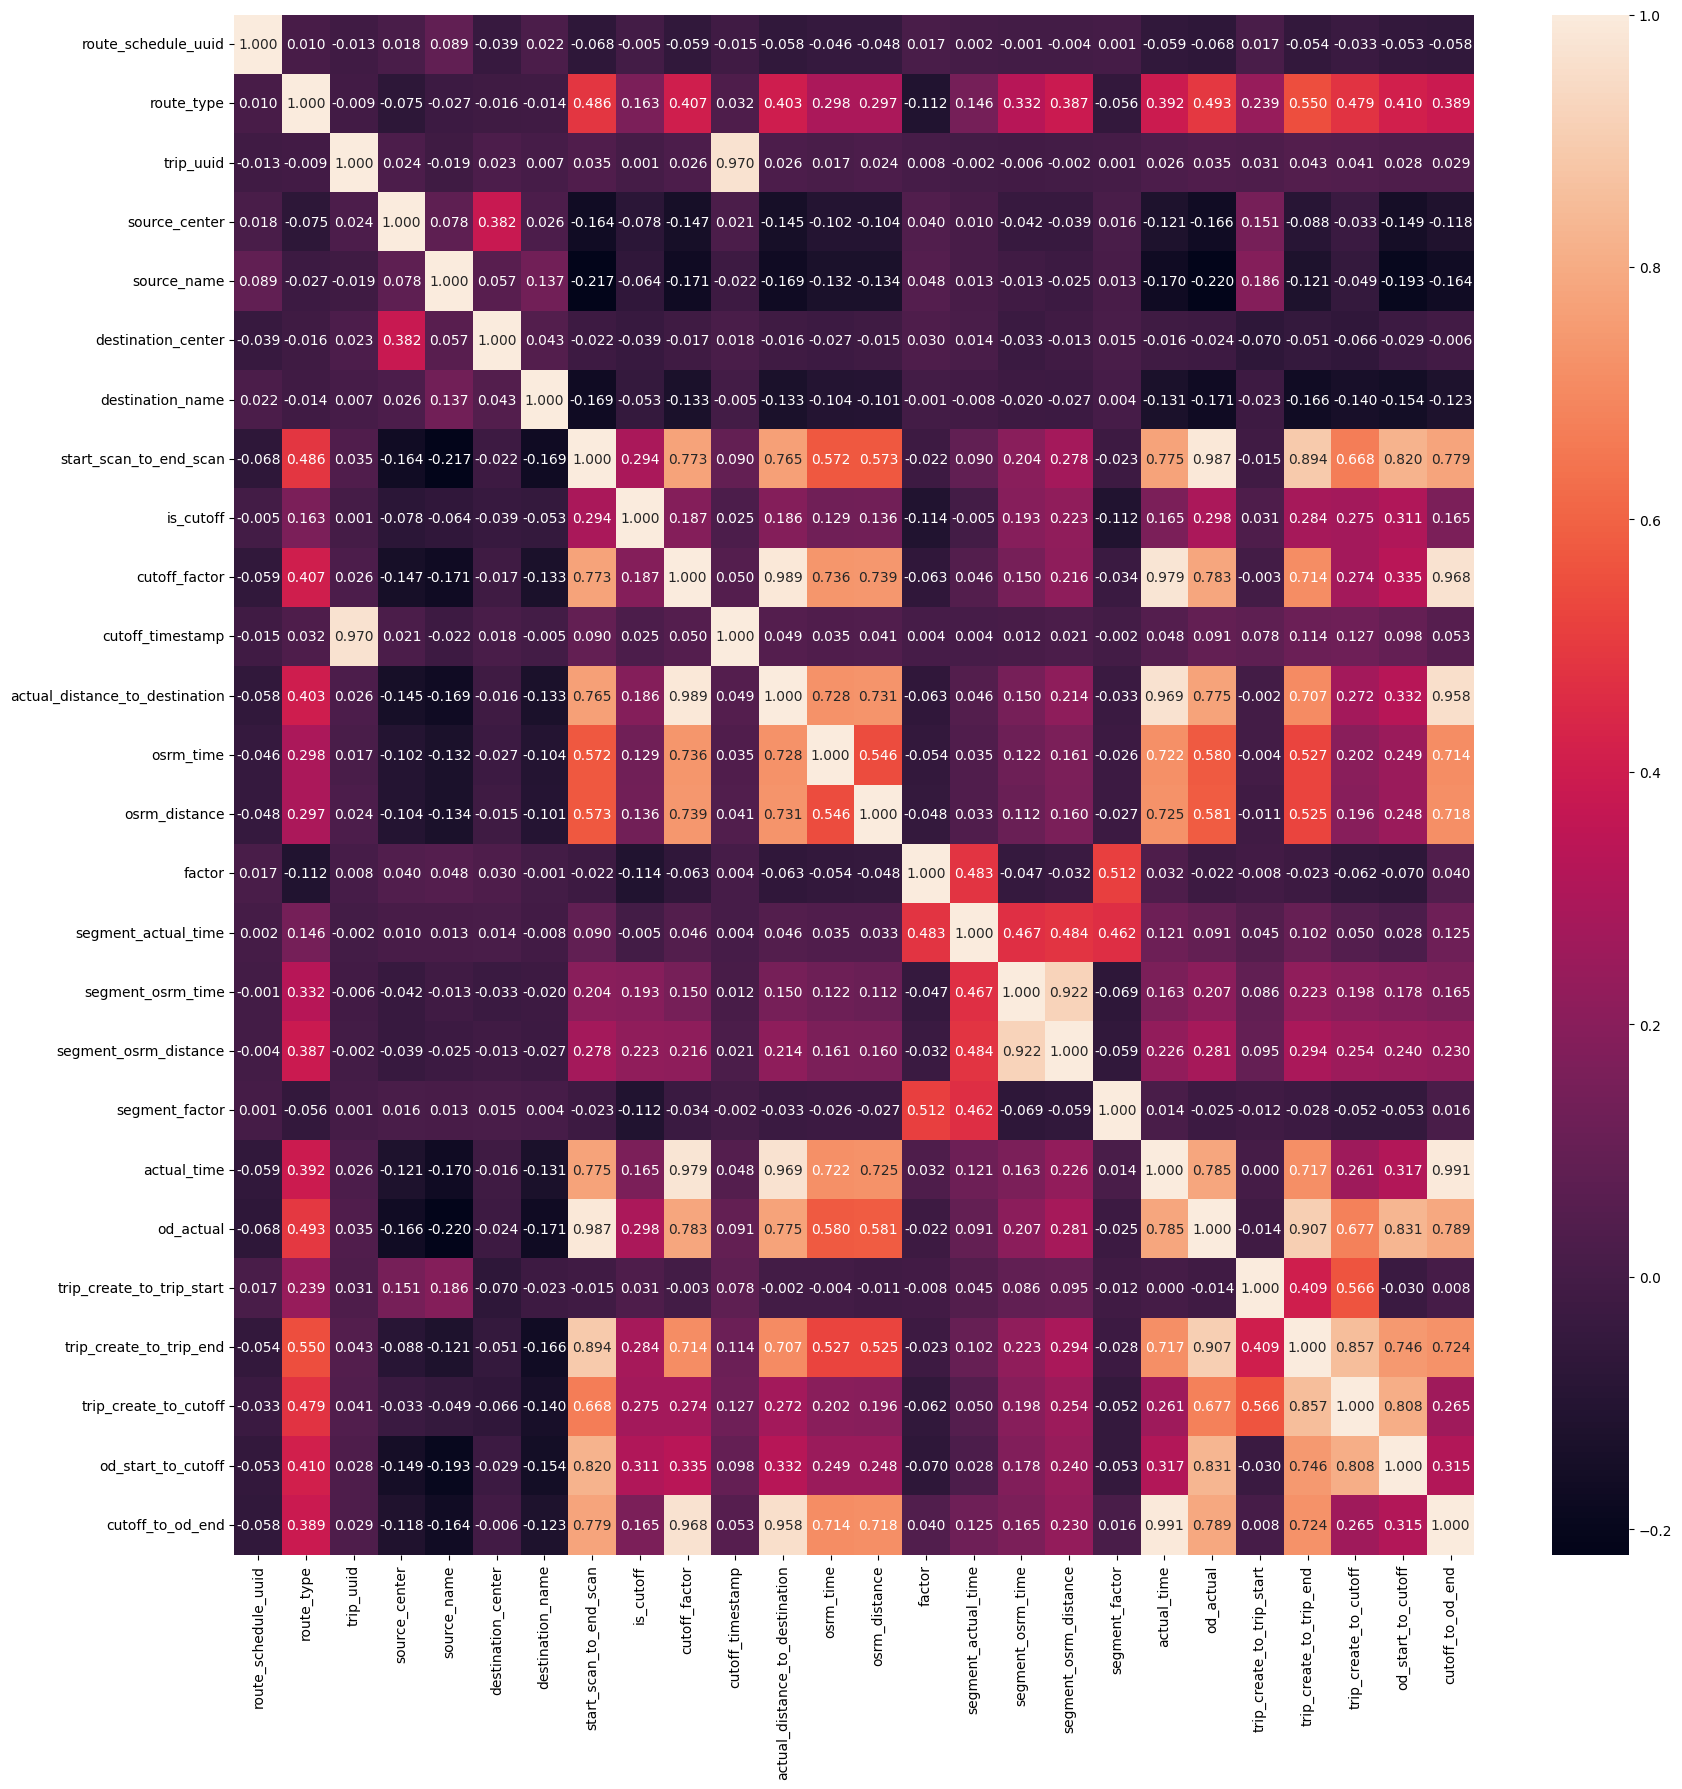

In [77]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,20)) 
import seaborn as sns
sns.heatmap(train_df.corr(),annot=True,ax=ax,fmt='.3f')

### conclusion of heatmap
We can see from the correlation heatmap that, columns:['cutoff_factor','start_scan_to_end_scan', 'actual_distance_to_destination', 'osrm_time',
       'osrm_distance', 'od_actual', 'trip_create_to_trip_end', 'cutoff_to_od_end'] has very high positive correlation with our target column 'actual_time'.

In [78]:
train_df.columns

Index(['route_schedule_uuid', 'route_type', 'trip_uuid', 'source_center',
       'source_name', 'destination_center', 'destination_name',
       'start_scan_to_end_scan', 'is_cutoff', 'cutoff_factor',
       'cutoff_timestamp', 'actual_distance_to_destination', 'osrm_time',
       'osrm_distance', 'factor', 'segment_actual_time', 'segment_osrm_time',
       'segment_osrm_distance', 'segment_factor', 'actual_time', 'od_actual',
       'trip_create_to_trip_start', 'trip_create_to_trip_end',
       'trip_create_to_cutoff', 'od_start_to_cutoff', 'cutoff_to_od_end'],
      dtype='object')

In [79]:
gc.collect()

18

In [80]:
# drop_col = ['route_schedule_uuid']

# train_df.drop(drop_col,axis=1,inplace=True)
# test_df.drop(drop_col,axis=1,inplace=True)

In [81]:
gc.collect()

0

In [82]:
train_df.isna().sum()

route_schedule_uuid                   0
route_type                            0
trip_uuid                             0
source_center                         0
source_name                           0
destination_center                    0
destination_name                      0
start_scan_to_end_scan                0
is_cutoff                             0
cutoff_factor                         0
cutoff_timestamp                      0
actual_distance_to_destination        0
osrm_time                         14432
osrm_distance                     14432
factor                             1644
segment_actual_time                   0
segment_osrm_time                     0
segment_osrm_distance                 0
segment_factor                     1159
actual_time                           0
od_actual                           720
trip_create_to_trip_start          3515
trip_create_to_trip_end            4203
trip_create_to_cutoff              4401
od_start_to_cutoff                  930


In [83]:
# All columns filled with it's mean
# train_df['osrm_time']=train_df['osrm_time'].fillna(train_df['osrm_time'].mean())
# train_df['osrm_distance']=train_df['osrm_distance'].fillna(train_df['osrm_distance'].mean())
# train_df['od_actual']=train_df['od_actual'].fillna(train_df['od_actual'].mean())
# train_df['trip_create_to_trip_end']=train_df['trip_create_to_trip_end'].fillna(train_df['trip_create_to_trip_end'].mean())


# # test_df['osrm_time']=test_df['osrm_time'].fillna(test_df['osrm_time'].mean())
# test_df['osrm_distance']=test_df['osrm_distance'].fillna(test_df['osrm_distance'].mean())
# test_df['od_actual']=test_df['od_actual'].fillna(test_df['od_actual'].mean())
# test_df['trip_create_to_trip_end']=test_df['trip_create_to_trip_end'].fillna(test_df['trip_create_to_trip_end'].mean())

<Axes: >

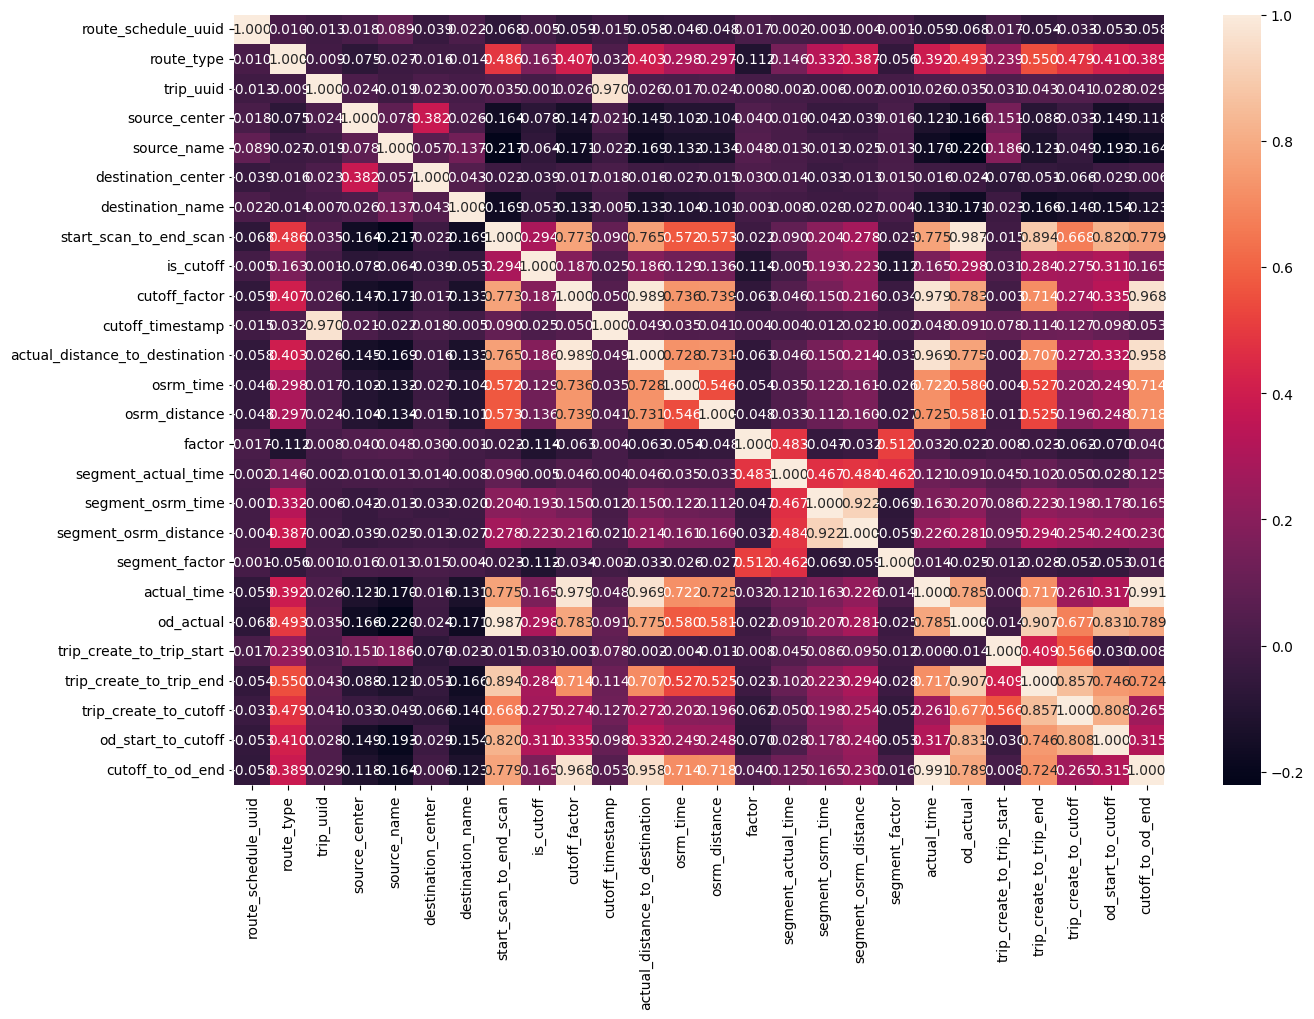

In [84]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,10)) 
import seaborn as sns
sns.heatmap(train_df.corr(),annot=True,ax=ax,fmt='.3f')

When I filled na values of dataset and then plot correlation, I saw that it's decreasing and my model performance is also decreased, so i decide to don't fill any na values as I'm using XGBRegressor model

### Splitting the train data to x_train and y_train and I'm using whole train data for train our model as test data is given seperately

In [85]:
X = train_df.drop('actual_time',axis=1)
y = train_df.actual_time
X.isna().sum()

route_schedule_uuid                   0
route_type                            0
trip_uuid                             0
source_center                         0
source_name                           0
destination_center                    0
destination_name                      0
start_scan_to_end_scan                0
is_cutoff                             0
cutoff_factor                         0
cutoff_timestamp                      0
actual_distance_to_destination        0
osrm_time                         14432
osrm_distance                     14432
factor                             1644
segment_actual_time                   0
segment_osrm_time                     0
segment_osrm_distance                 0
segment_factor                     1159
od_actual                           720
trip_create_to_trip_start          3515
trip_create_to_trip_end            4203
trip_create_to_cutoff              4401
od_start_to_cutoff                  930
cutoff_to_od_end                   1638


In [86]:
gc.collect()

15

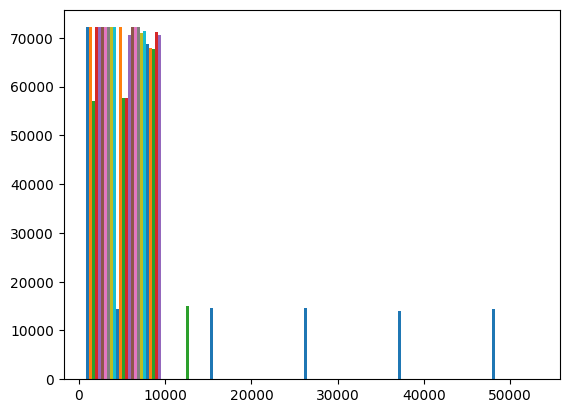

In [87]:
plt.hist(X, bins=5)
plt.show()

In [88]:
X.head()

,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,start_scan_to_end_scan,is_cutoff,cutoff_factor,...,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor,od_actual,trip_create_to_trip_start,trip_create_to_trip_end,trip_create_to_cutoff,od_start_to_cutoff,cutoff_to_od_end
0,857,1,2126,1412,635,1389,1162,713.521495,1,44,...,77.988686,20.793472,28.475783,3.292773,4.171435,0.000000,4.171435,2.367873,2.367873,1.803562
1,1026,1,11676,584,1006,577,198,902.759458,1,22,...,68.517914,18.787231,34.612259,4.277350,8.173260,7.506925,15.680185,14.511397,7.004471,1.168788
2,758,1,7806,1427,1190,1433,948,923.666146,1,22,...,70.475386,24.371978,29.867950,5.322072,7.306614,5.680661,12.987275,11.095379,5.414718,1.891896
3,821,1,6106,1417,966,1430,1124,705.451567,1,176,...,101.876844,19.588977,27.794019,4.265799,9.147125,28.946600,38.093725,32.958935,4.012335,5.134790
4,999,1,4001,542,1138,719,567,1109.682268,1,198,...,46.571301,22.671495,26.971844,3.553652,16.799587,0.000000,16.799587,11.054184,11.054184,5.745403


In this model I don't used to normalised our dataset because after normalized our dataset, model is performed very worst. loss is around 1000 and more after submission. XD.

### **Model training and exploration**

In [89]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from xgboost import XGBRegressor

In [90]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,accuracy_score

In [91]:
# models = {'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
#           'RandomForestRegressor': RandomForestRegressor(random_state=42),
#          'XGBRegressor': XGBRegressor(eval_metric=r2_score)}

# params = {
#     "n_estimators": 2000,
#     "max_depth": 4,
#     "min_samples_split": 5,
#     "learning_rate": 0.01,
#     "loss": "squared_error",
#     "random_state": 1
# }


# model = GradientBoostingRegressor(**params)
model = XGBRegressor()


I don't use hyperparameter tunning because it's don't running on my laptop :).
leave it around 2 hr to fit the model but it doesn't fitted. :)

In [92]:
# def train(model, X_train, y_train):
#     model.fit(X_train, y_train)
#     return model
model.fit(X,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [93]:

# def score(model, X_test, y_test):
#     predictions = model.predict(X_test)
    
#     r2 = r2_score(y_test, predictions)
    
#     rmse = np.sqrt(mean_squared_error(y_test, predictions))
   
#     print('RMSE:', rmse)
#     print('R-Squared:', r2)
#     print()
#     return [r2, rmse]
# predictions = model.predict(X_test)
# print('r2-score:',r2_score(y_test,predictions))
# print('rmse:',np.sqrt(mean_squared_error(y_test, predictions)))

In [94]:
# scoring1 = pd.DataFrame()
# scoring1['Metric'] = ['R2_score', 'RMSE']

In [95]:
# # Using the training set X_train
# for name, func in models.items():
#     print(f'Performance of {name} on Test:')
#     print('=='*24)
#     print ('Test set:')
#     print("**"*8)
    
#     model = train(func, X_train, y_train)
#     results = score(model, X_test, y_test)
#     scoring1[name] = results

In [96]:
# scoring1

In [97]:
# models = [GradientBoostingRegressor(random_state=42),
#           RandomForestRegressor(random_state=42),
#           XGBRegressor(eval_metric=r2_score)]


In [98]:
# Fit each model on the training set and make predictions on the testing set
# for model in models:
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     rmse = mean_squared_error(y_test, y_pred, squared=False)
#     print(f"{type(model).__name__} RMSE: {rmse:.2f}")

So here I used some of models but I saw that XGBRegressor giving much better performance, That's why I used this model

## **Working on Test dataset**

In [99]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72158 entries, 0 to 72157
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   route_schedule_uuid             72158 non-null  int64  
 1   route_type                      72158 non-null  int64  
 2   trip_uuid                       72158 non-null  int64  
 3   source_center                   72158 non-null  int64  
 4   source_name                     72158 non-null  int64  
 5   destination_center              72158 non-null  int64  
 6   destination_name                72158 non-null  int64  
 7   start_scan_to_end_scan          72158 non-null  float64
 8   is_cutoff                       72158 non-null  int64  
 9   cutoff_factor                   72158 non-null  int64  
 10  cutoff_timestamp                72158 non-null  int64  
 11  actual_distance_to_destination  72158 non-null  float64
 12  osrm_time                       

In [100]:
test_df.isna().sum()

route_schedule_uuid               0
route_type                        0
trip_uuid                         0
source_center                     0
source_name                       0
destination_center                0
destination_name                  0
start_scan_to_end_scan            0
is_cutoff                         0
cutoff_factor                     0
cutoff_timestamp                  0
actual_distance_to_destination    0
osrm_time                         0
osrm_distance                     0
factor                            0
segment_actual_time               0
segment_osrm_time                 0
segment_osrm_distance             0
segment_factor                    0
od_actual                         0
trip_create_to_trip_start         0
trip_create_to_trip_end           0
trip_create_to_cutoff             0
od_start_to_cutoff                0
cutoff_to_od_end                  0
dtype: int64

In [101]:
test_df.head()

,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,start_scan_to_end_scan,is_cutoff,cutoff_factor,...,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor,od_actual,trip_create_to_trip_start,trip_create_to_trip_end,trip_create_to_cutoff,od_start_to_cutoff,cutoff_to_od_end
0,1322,0,5416,482,48,473,714,86.0,1,27,...,16.0,7.0,10.8152,2.285714,1.436894,0.765539,2.202433,1.428619,0.663080,0.773814
1,1322,0,5416,482,48,473,714,86.0,0,39,...,6.0,5.0,3.9153,1.200000,1.436894,0.765539,2.202433,0.971812,0.206273,1.230621
2,1322,0,5416,485,735,472,43,109.0,1,9,...,15.0,11.0,12.1171,1.363636,1.819553,2.202433,4.021986,3.672645,1.470212,0.349341
3,1322,0,5416,485,735,472,43,109.0,1,36,...,10.0,10.0,11.3648,1.000000,1.819553,2.202433,4.021986,2.672090,0.469656,1.349897
4,1461,1,7485,587,201,537,1109,302.0,1,22,...,38.0,24.0,26.8622,1.583333,5.039540,0.000000,5.039540,4.386938,4.386938,0.652602


In [102]:
test_df.shape

(72158, 25)

In [103]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# num_cols = train_df.select_dtypes(include=['int', 'float']).columns
# train_df[num_cols] = scaler.fit_transform(train_df[num_cols])


In [104]:
X.shape

(72158, 25)

In [105]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72158 entries, 0 to 72157
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   route_schedule_uuid             72158 non-null  int64  
 1   route_type                      72158 non-null  int64  
 2   trip_uuid                       72158 non-null  int64  
 3   source_center                   72158 non-null  int64  
 4   source_name                     72158 non-null  int64  
 5   destination_center              72158 non-null  int64  
 6   destination_name                72158 non-null  int64  
 7   start_scan_to_end_scan          72158 non-null  float64
 8   is_cutoff                       72158 non-null  int64  
 9   cutoff_factor                   72158 non-null  int64  
 10  cutoff_timestamp                72158 non-null  int64  
 11  actual_distance_to_destination  72158 non-null  float64
 12  osrm_time                       

In [106]:
# xgb = XGBRegressor(eval_metric=r2_score)
# xgb.fit(X_train, y_train)

predicted = model.predict(test_df)

In [107]:
output = sample_submission
submit = pd.DataFrame({'UID':output['UID'],
                       'actual_time':(predicted).astype(float)})

In [108]:
submit.head()

,UID,actual_time
0,XMsT9clviB,34.840469
1,1iUuyRUZ2Y,62.704227
2,wancwiAIU3,10.074304
3,1tIt8EwJjB,59.876286
4,W2vL6bJrjt,29.556368


Creating csv file for Our predicted value

In [109]:
submit.to_csv('submission1.csv',index=False)

In [110]:
submit

,UID,actual_time
0,XMsT9clviB,34.840469
1,1iUuyRUZ2Y,62.704227
2,wancwiAIU3,10.074304
3,1tIt8EwJjB,59.876286
4,W2vL6bJrjt,29.556368
...,...,...
72153,L5IrEpNBFb,29.783228
72154,s5TDXjnN3s,42.183430
72155,0croXy5yK5,52.559525
72156,P0okvBa2Ik,78.861900


## Saving Our model to pkl file

In [114]:
# from sklearn.externals import joblib
import joblib


# Save the model as a pickle file
joblib.dump(model, 'cassandra_ps2.pkl')

['cassandra_ps2.pkl']